In [1]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import time
import sklearn
import torch
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
df = pd.read_csv("untokenized_df.csv")
print(f"Dataset's shape: {df.shape}")
print(df.columns)

Dataset's shape: (6152, 9)
Index(['index', 'artist', 'lyrics', 'song_name', 'artist_key', 'url',
       'words count', 'unique words count', 'lyricist'],
      dtype='object')


In [3]:
example_song = df.query("song_name == 'לקחת את ידי בידך'")["lyrics"].index[0]
df["lyrics"][example_song]

'<s> לקחת את ידי בידך ואמרת לי: <\\s> <s> בואי נרד אל הגן. <\\s> <s> לקחת את ידי בידך ואמרת לי: <\\s> <s> דברים שרואים משם - לא רואים מכאן <\\s> <s>  <\\s> <s> ניגנת לי שיר על הגיטרה וקולך רעד <\\s> <s> רוח בי קמה, רוח שרה, והזמן כאילו עמד <\\s> <s> ואני עוד זוכרת כל טעם וריח <\\s> <s> את חלקת השדה לאור הירח <\\s> <s> קול התן מן הואדי וכובד הפרי בבוסתן, <\\s> <s> דברים שרואים משם לא רואים מכאן. <\\s> <s>  <\\s> <s> הייתי לבדי ודרכי אבדה לי <\\s> <s> ובאת, באת לי בזמן. <\\s> <s> הייתי לבדי ודרכי אבדה לי <\\s> <s> דברים שרואים משם לא רואים מכאן. <\\s> <s>  <\\s> <s> נתת לי יד, הראית לי דרך להרבה דברים <\\s> <s> הבאת חיוך יפה כמו פרח וכח להאמין. <\\s> <s> ואני עוד זוכרת את השיר ששרת <\\s> <s> את החלק הטוב מכל מה שאמרת. <\\s> <s> היי, מלאך ושטן, התשוב לעצור את הזמן <\\s> <s> דברים שרואים משם לא רואים מכאן. <\\s> '

In [4]:
df["lyrics"] = df["lyrics"].apply(lambda x: x.replace("<s>", "").replace("<\\s>", "</s>").replace("</s></s>", "</s>"))

In [5]:
df["lyrics"][example_song]

' לקחת את ידי בידך ואמרת לי: </s>  בואי נרד אל הגן. </s>  לקחת את ידי בידך ואמרת לי: </s>  דברים שרואים משם - לא רואים מכאן </s>   </s>  ניגנת לי שיר על הגיטרה וקולך רעד </s>  רוח בי קמה, רוח שרה, והזמן כאילו עמד </s>  ואני עוד זוכרת כל טעם וריח </s>  את חלקת השדה לאור הירח </s>  קול התן מן הואדי וכובד הפרי בבוסתן, </s>  דברים שרואים משם לא רואים מכאן. </s>   </s>  הייתי לבדי ודרכי אבדה לי </s>  ובאת, באת לי בזמן. </s>  הייתי לבדי ודרכי אבדה לי </s>  דברים שרואים משם לא רואים מכאן. </s>   </s>  נתת לי יד, הראית לי דרך להרבה דברים </s>  הבאת חיוך יפה כמו פרח וכח להאמין. </s>  ואני עוד זוכרת את השיר ששרת </s>  את החלק הטוב מכל מה שאמרת. </s>  היי, מלאך ושטן, התשוב לעצור את הזמן </s>  דברים שרואים משם לא רואים מכאן. </s> '

In [6]:
print(df["lyrics"][example_song].replace("</s>", "\n"))

 לקחת את ידי בידך ואמרת לי: 
  בואי נרד אל הגן. 
  לקחת את ידי בידך ואמרת לי: 
  דברים שרואים משם - לא רואים מכאן 
   
  ניגנת לי שיר על הגיטרה וקולך רעד 
  רוח בי קמה, רוח שרה, והזמן כאילו עמד 
  ואני עוד זוכרת כל טעם וריח 
  את חלקת השדה לאור הירח 
  קול התן מן הואדי וכובד הפרי בבוסתן, 
  דברים שרואים משם לא רואים מכאן. 
   
  הייתי לבדי ודרכי אבדה לי 
  ובאת, באת לי בזמן. 
  הייתי לבדי ודרכי אבדה לי 
  דברים שרואים משם לא רואים מכאן. 
   
  נתת לי יד, הראית לי דרך להרבה דברים 
  הבאת חיוך יפה כמו פרח וכח להאמין. 
  ואני עוד זוכרת את השיר ששרת 
  את החלק הטוב מכל מה שאמרת. 
  היי, מלאך ושטן, התשוב לעצור את הזמן 
  דברים שרואים משם לא רואים מכאן. 
 


In [ ]:
char_count = [len(s) for s in df["lyrics"].tolist()]
char_count = np.array(char_count)
print("Character count statistics:")
print(f"Mean: {char_count.mean()}, Std: {char_count.std()}, Min: {char_count.min()}, Max: {char_count.max()}")

song_lengths = [len(s.strip().split(" ")) for s in df["lyrics"].tolist()]
song_lengths = np.array(song_lengths)
print("Song word count statistics:")
print(f"Mean: {song_lengths.mean()}, Std: {song_lengths.std()}, Min: {song_lengths.min()}, Max: {song_lengths.max()}")

In [ ]:
sns.histplot(char_count, bins=100, kde=True)
plt.title("Distribution of the number of characters per song")
plt.xlabel("Number of characters")
plt.ylabel("Number of songs")
plt.show()

In [ ]:
sns.histplot(song_lengths, bins=100, kde=True)
plt.title("Distribution of the number of words per song")
plt.xlabel("Number of words")
plt.ylabel("Number of songs")
plt.show()

## Using API to segment the songs

We use the API provided by https://www.langndata.com/heb_parser to segment the lyrics.
It uses [YAP](https://github.com/onlplab/yap), a tool written in Go, with the following features:
- Tokenizer

- Segmentation

- Lemmas

- Part-of-speech

- Dependency tree

- Morphological analyzer

- Lattices

YAP is based on the work of Amir More and Amit Seker, developed at the ONLP research lab and led by Dr. Reut Tsarfaty, from the Department of Computer Science and Engineering, Bar-Ilan University.


The API is free to use, but requires registration, and has the following limitations:
1. 1 call per 3 seconds
2. 250 words max per call
3. Request length cannot exceed 1024 characters

In [ ]:
print(f"Number of songs with more than 1024 characters: {np.sum(char_count > 1024)}")
print(f"Number of songs with more than 250 words: {np.sum(song_lengths > 250)}")
print(
    f"Number of songs with more than 1024 characters or 250 words: {np.sum(np.logical_or(char_count > 1024, song_lengths > 250))}")

In [ ]:
API_token = "5e269f277bfcf9837ccd16181afe9fe0"

In [ ]:
text = df["lyrics"][example_song]
# Escape double quotes in JSON.
text = text.replace(r'"', r'\"')
url = f'https://www.langndata.com/api/heb_parser?token={API_token}'
_json = '{"data":"' + text + '"}'
headers = {'content-type': 'application/json'}
r = requests.post(url, data=_json.encode('utf-8'), headers={'Content-type': 'application/json; charset=utf-8'})
print(f"Tokenized text: {r.json()['tokenized_text']}")
print(f"Segmented text: {r.json()['segmented_text']}")
print(f"lemmatized text: {r.json()['lemmas']}")

In [ ]:
next_time_to_sleep = time.time() + 3.1

def split_lyrics(lyrics):
    words = lyrics.split(" ")

    chunks = []
    current_chunk = []
    current_chunk_chars_count = 0
    current_chunk_words_count = 0
    for word in words:
        if (current_chunk_chars_count + len(word) + 1 >= 1020) or current_chunk_words_count >= 240:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_chunk_chars_count = 0
            current_chunk_words_count = 0
        else:
            current_chunk.append(word)
            current_chunk_chars_count += len(word) + 1
            current_chunk_words_count += 1

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


def segment_text(text):
    if text == "":
        return ""
    text = text.replace(r'"', r'\"')
    url = f'https://www.langndata.com/api/heb_parser?token={API_token}'
    _json = '{"data":"' + text + '"}'
    headers = {'content-type': 'application/json'}
    global next_time_to_sleep
    if next_time_to_sleep > time.time():
        time.sleep(next_time_to_sleep - time.time())
    r = requests.post(url, data=_json.encode('utf-8'), headers={'Content-type': 'application/json; charset=utf-8'})
    next_time_to_sleep = time.time() + 3.1
    if "segmented_text" not in r.json():
        print(f"Error: {text, r.json()}")
        return ""
    return r.json()["segmented_text"]

In [ ]:
res = split_lyrics(df.query("song_name == 'ליל חניה'")["lyrics"].values[0])
print(f"Number of chunks: {len(res)}")
print(f"Number of characters in the first chunk: {len(res[0])}")
print(f"Number of words in the first chunk: {len(res[0].split(' '))}")
if len(res) > 1:
    print(f"Number of characters in the second chunk: {len(res[1])}")
    print(f"Number of words in the second chunk: {len(res[1].split(' '))}")
" ".join([segment_text(chunk) for chunk in res]).replace("רצףסוףמשפט", "</s>")

In [7]:
if False:
    tqdm.pandas()
    df["lyrics"] = df["lyrics"].apply(lambda x: x.replace("</s>", "רצףסוףמשפט"))
    df["lyrics_chunks"] = df["lyrics"].apply(split_lyrics)
    df["segmented_lyrics"] = df["lyrics_chunks"].progress_apply(lambda x: " ".join([segment_text(chunk) for chunk in x]))
    df["lyrics"] = df["segmented_lyrics"].apply(lambda x: x.replace("רצףסוףמשפט", "</s>"))
    df.to_csv("segmented_lyrics.csv", index=False)

df = pd.read_csv("segmented_lyrics.csv")
df = df.drop(columns=["lyrics_chunks", "segmented_lyrics"])
df.head()

,index,artist,lyrics,song_name,artist_key,url,words count,unique words count,lyricist
0,5910,אילנית,מישהו מתחיל ל ה שיר ב שקט </s> ו אחר עונה ל הו...,עכשיו כולם ביחד,Artist_Ilanit,http://shironet.mako.co.il/artist?type=lyrics&...,109,57,אהוד מנור
1,5794,אילנית,"הלכתי לחפש את גן ה משחקים , </s> את גן ה משחקי...",איה הגן,Artist_Ilanit,http://shironet.mako.co.il/artist?type=lyrics&...,128,71,אהוד מנור
2,12830,ירדנה ארזי,"ה אדם ב ה צלם , </s> הוא יצור מופלא ! </s> בין...",האדם יצור מופלא,Artist_Yardena_Arazi,http://shironet.mako.co.il/artist?type=lyrics&...,105,78,אהוד מנור
3,12835,ירדנה ארזי,"עוד שנה חלפה , </s> עוד שנה טרופה , </s> עשבים...",הביתה,Artist_Yardena_Arazi,http://shironet.mako.co.il/artist?type=lyrics&...,137,97,אהוד מנור
4,12838,ירדנה ארזי,ה מסך שוב עולה </s> על במה עגולה </s> אור ה שמ...,ההצגה הגדולה,Artist_Yardena_Arazi,http://shironet.mako.co.il/artist?type=lyrics&...,104,81,אהוד מנור


## Split again to train / validation

In [15]:
from sklearn.model_selection import train_test_split
df["lyrics_as_list"] = df["lyrics"].astype(str).str.strip().str.split(" ")
lyricists = df['lyricist']
# artists = df['artist'] # maybe we can try this one later.
lyrics = df['lyrics_as_list']


X_train, _, y_train, _ = train_test_split(lyrics, lyricists, test_size=0.15, stratify=lyricists)
X_train, X_test, y_train, y_test = train_test_split(lyrics, lyricists, test_size=0.15, stratify=lyricists)
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['lyrics','lyricist'])
val_df = pd.DataFrame(np.c_[ X_test,y_test], columns = ['lyrics','lyricist'])

In [18]:
with open('../words_list_w2v.txt',encoding='utf-8') as f:
    words = f.read().split('\n')
    # Removing the last word - an empty word
    words.pop()
vectors = np.load('../words_vectors_w2v.npy')

words = [w[3:] if len(w)>3 and w[:3] in ['NN_','VB_','JJ_'] else w for w in words]

from collections import defaultdict, OrderedDict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
            if len(locs)>1)

dups_indx = [dup for dup in sorted(list_duplicates(words))]


words = list(OrderedDict.fromkeys(words))
vectors_without_dups = vectors.copy()
to_delete = []
for d in dups_indx:
    indices = sorted(d[1])
    vectors_without_dups[indices[0]] = np.mean(vectors[indices])
    to_delete = to_delete + indices[1:]
vectors = np.delete(vectors_without_dups, to_delete, 0)


w2v = dict(zip(words,vectors))
v2w_rep = dict(zip([tuple(v) for v in vectors],words))
def v2w(vector):
    return v2w_rep[tuple(vector)]


def song2vec_mean(song):
    return np.mean([w2v[w] for w in song if w in words],axis=0)

def song2vec_max(song):
    return np.max([w2v[w] for w in song if w in words], axis=0)

words_set = set(words)
train_df['song2vec_mean'] = train_df['lyrics'].map(lambda l: np.mean([w2v[w] for w in l if w in words_set],axis=0))
train_df = train_df.dropna()
train_df['song2vec_max'] = train_df['lyrics'].map(lambda l: np.max([w2v[w] for w in l if w in words_set],axis=0))

val_df['song2vec_mean'] = val_df['lyrics'].map(lambda l: np.mean([w2v[w] for w in l if w in words_set],axis=0))
val_df = val_df.dropna()
val_df['song2vec_max'] = val_df['lyrics'].map(lambda l: np.max([w2v[w] for w in l if w in words_set],axis=0))

In [21]:
train_df["lyricist"].value_counts()

אהוד מנור     309
זאב נחמה      185
שלמה ארצי     174
שלום חנוך     154
אביב גפן      141
             ... 
עילי בוטנר     44
שאנן סטריט     44
דורון מדלי     44
רונה קינן      43
חמי רודנר      43
Name: lyricist, Length: 65, dtype: int64

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import patches as mpatches


def project_lyricists(lyricists_to_project):
    songs_to_project = train_df['lyricist'].isin(lyricists_to_project)
    labels = [lyricists_to_project.index(a) for a in train_df['lyricist'][songs_to_project]]
    cmap = plt.cm.get_cmap('viridis', len(lyricists_to_project))

    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)
    umap = UMAP(n_components=2)

    pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    tsne = Pipeline([('scaler', StandardScaler()), ('tsne', tsne)])
    umap = Pipeline([('scaler', StandardScaler()), ('umap', umap)])

    pca_s2v_mean = pca.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())
    tsne_s2v_mean = tsne.fit_transform(np.array(train_df['song2vec_mean'][songs_to_project].to_list()))
    umap_s2v_mean = umap.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())

    pca_s2v_max = pca.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())
    tsne_s2v_max = tsne.fit_transform(np.array(train_df['song2vec_max'][songs_to_project].to_list()))
    umap_s2v_max = umap.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())

    fig, axes = plt.subplots(2, 3, figsize=(15, 15))
    fig.suptitle('Embedding space exploration', fontsize=16)
    fig.legend(
        handles=[mpatches.Patch(color=cmap(i), label=lyricists_to_project[i][::-1]) for i in range(len(lyricists_to_project))],
        loc='upper right')
    axes[0, 0].set_title('PCA - song2vec AvgPooling')
    axes[0, 0].scatter(pca_s2v_mean[:, 0], pca_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[0, 1].set_title('TSNE - song2vec AvgPooling')
    axes[0, 1].scatter(tsne_s2v_mean[:, 0], tsne_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[0, 2].set_title('UMAP - song2vec AvgPooling')
    axes[0, 2].scatter(umap_s2v_mean[:, 0], umap_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')

    axes[1, 0].set_title('PCA - song2vec MaxPooling')
    axes[1, 0].scatter(pca_s2v_max[:, 0], pca_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[1, 1].set_title('TSNE - song2vec MaxPooling')
    axes[1, 1].scatter(tsne_s2v_max[:, 0], tsne_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[1, 2].set_title('UMAP - song2vec MaxPooling')
    axes[1, 2].scatter(umap_s2v_max[:, 0], umap_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')

    plt.show()

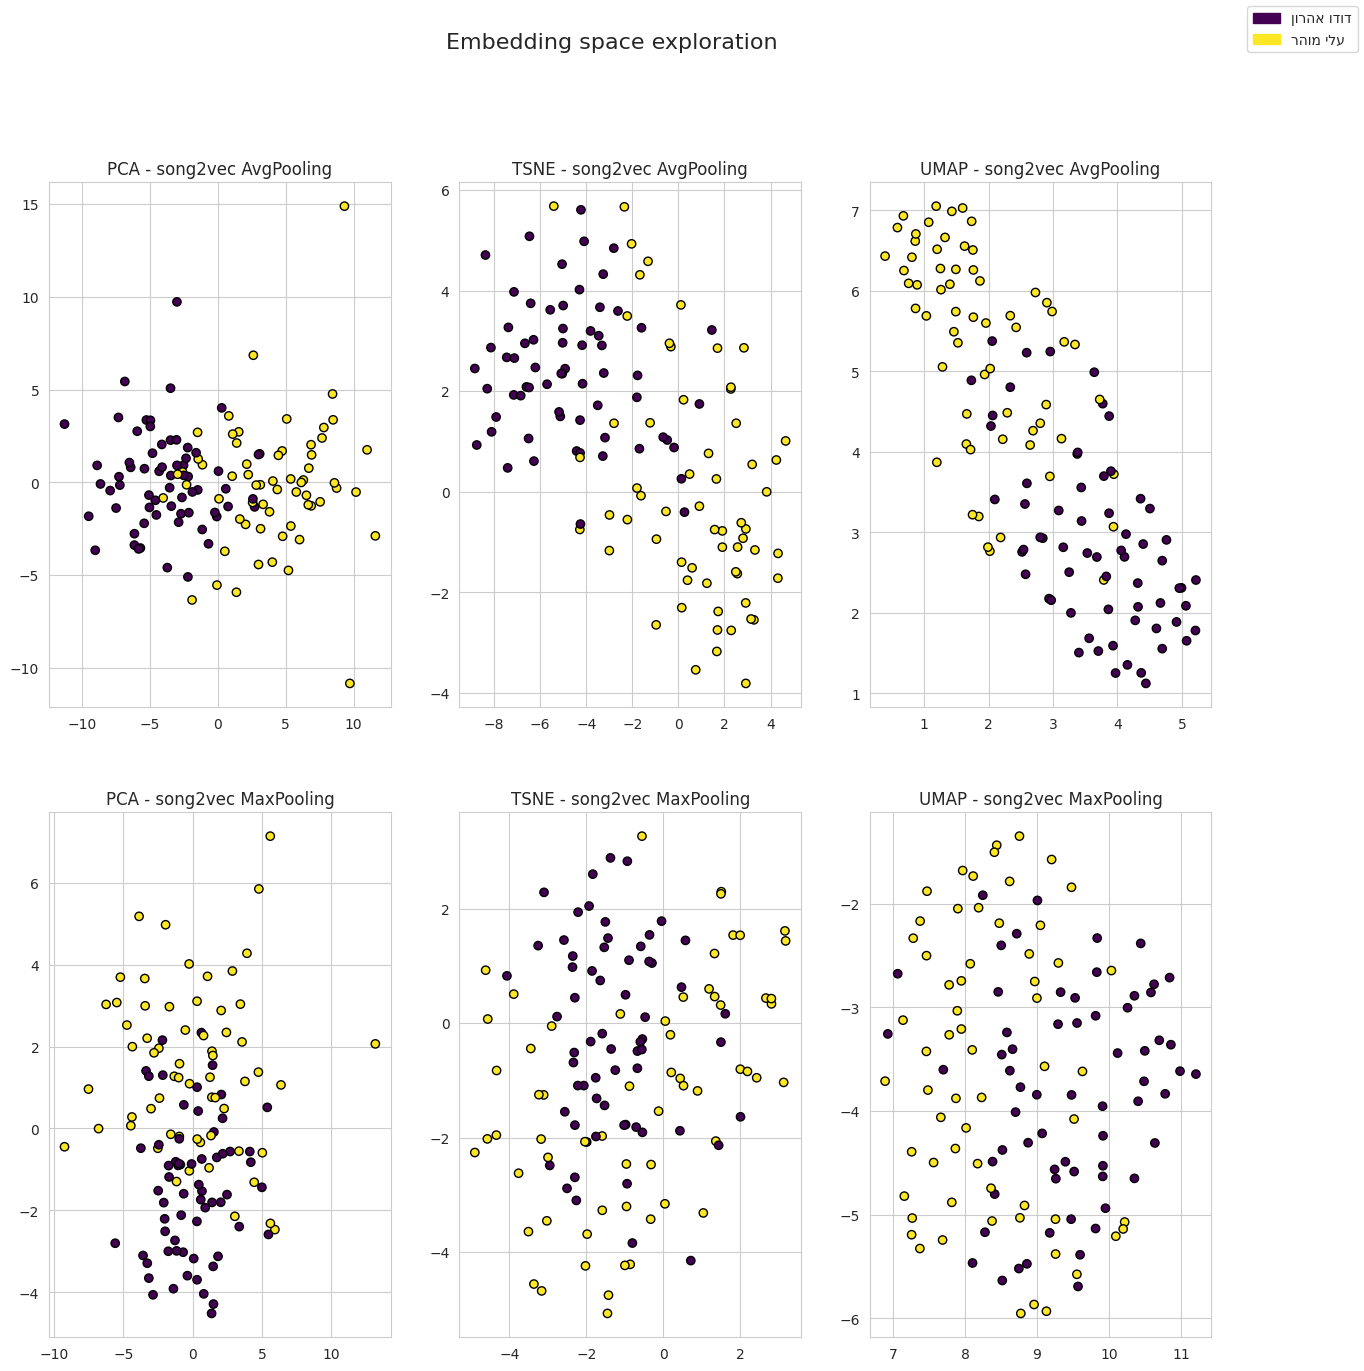

In [46]:
project_lyricists(["דודו אהרון", "עלי מוהר"])

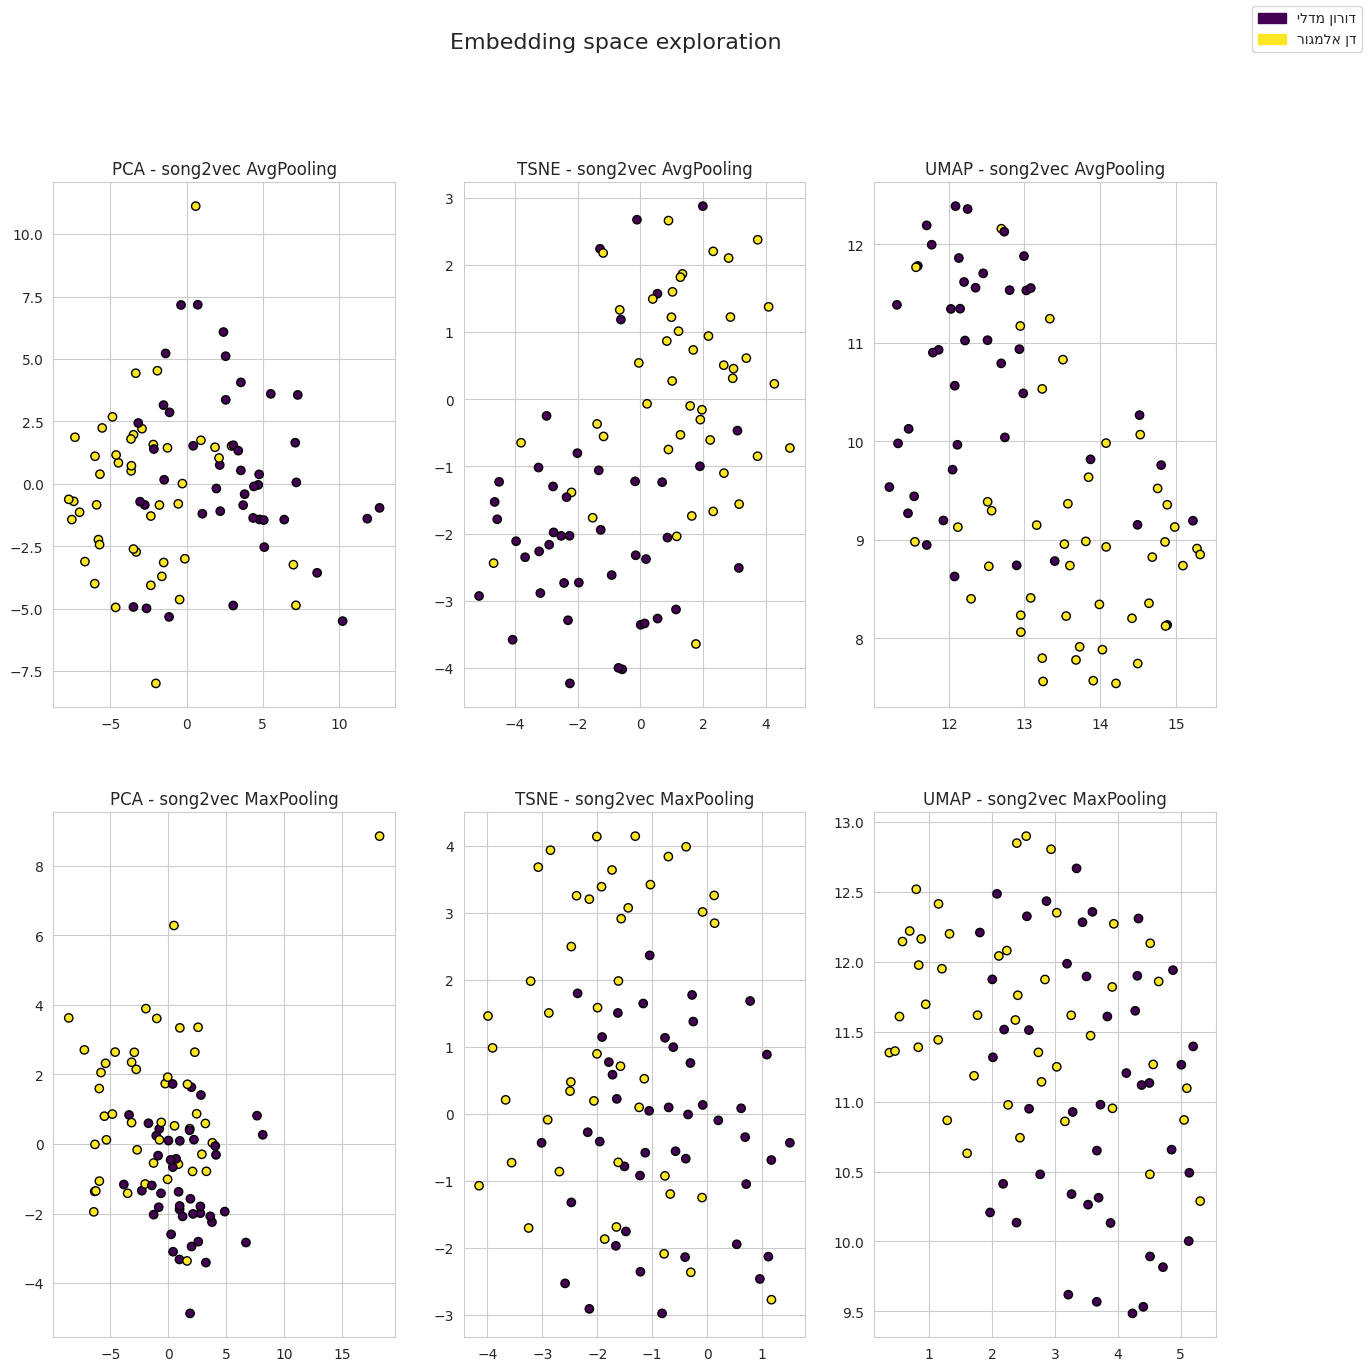

In [47]:
project_lyricists(["דורון מדלי", "דן אלמגור"])

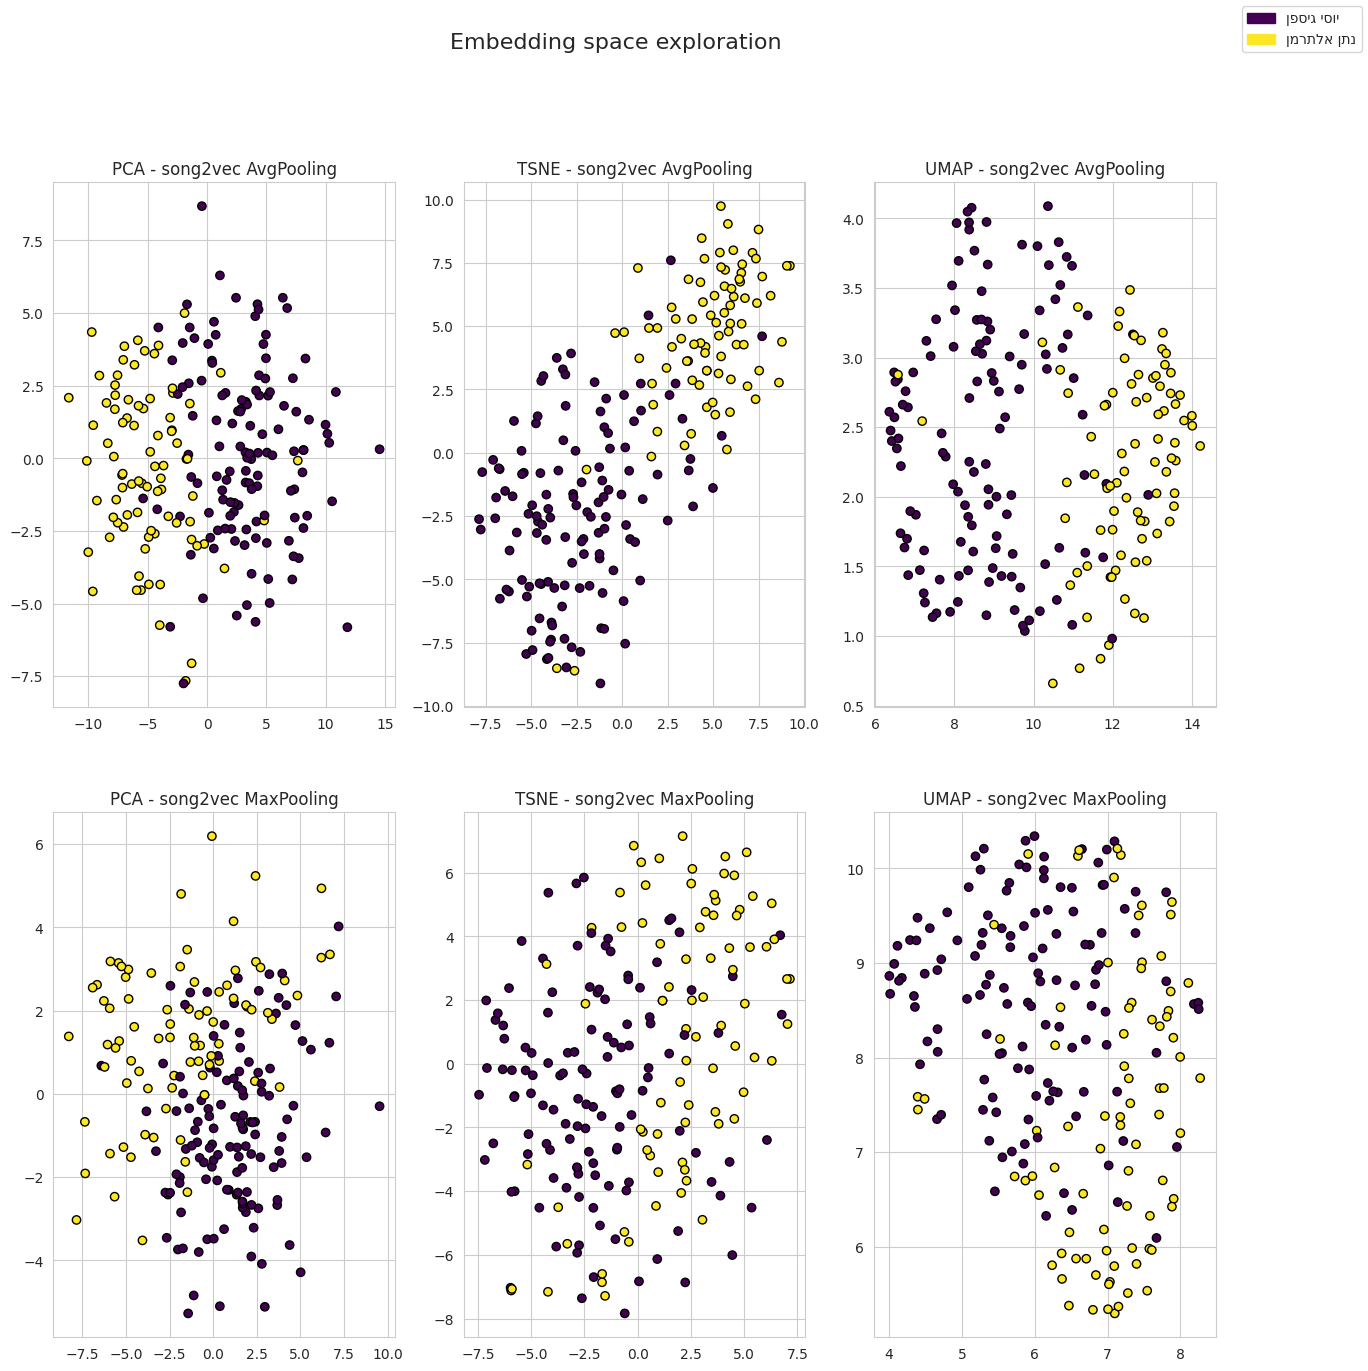

In [48]:
project_lyricists(["יוסי גיספן", "נתן אלתרמן"])

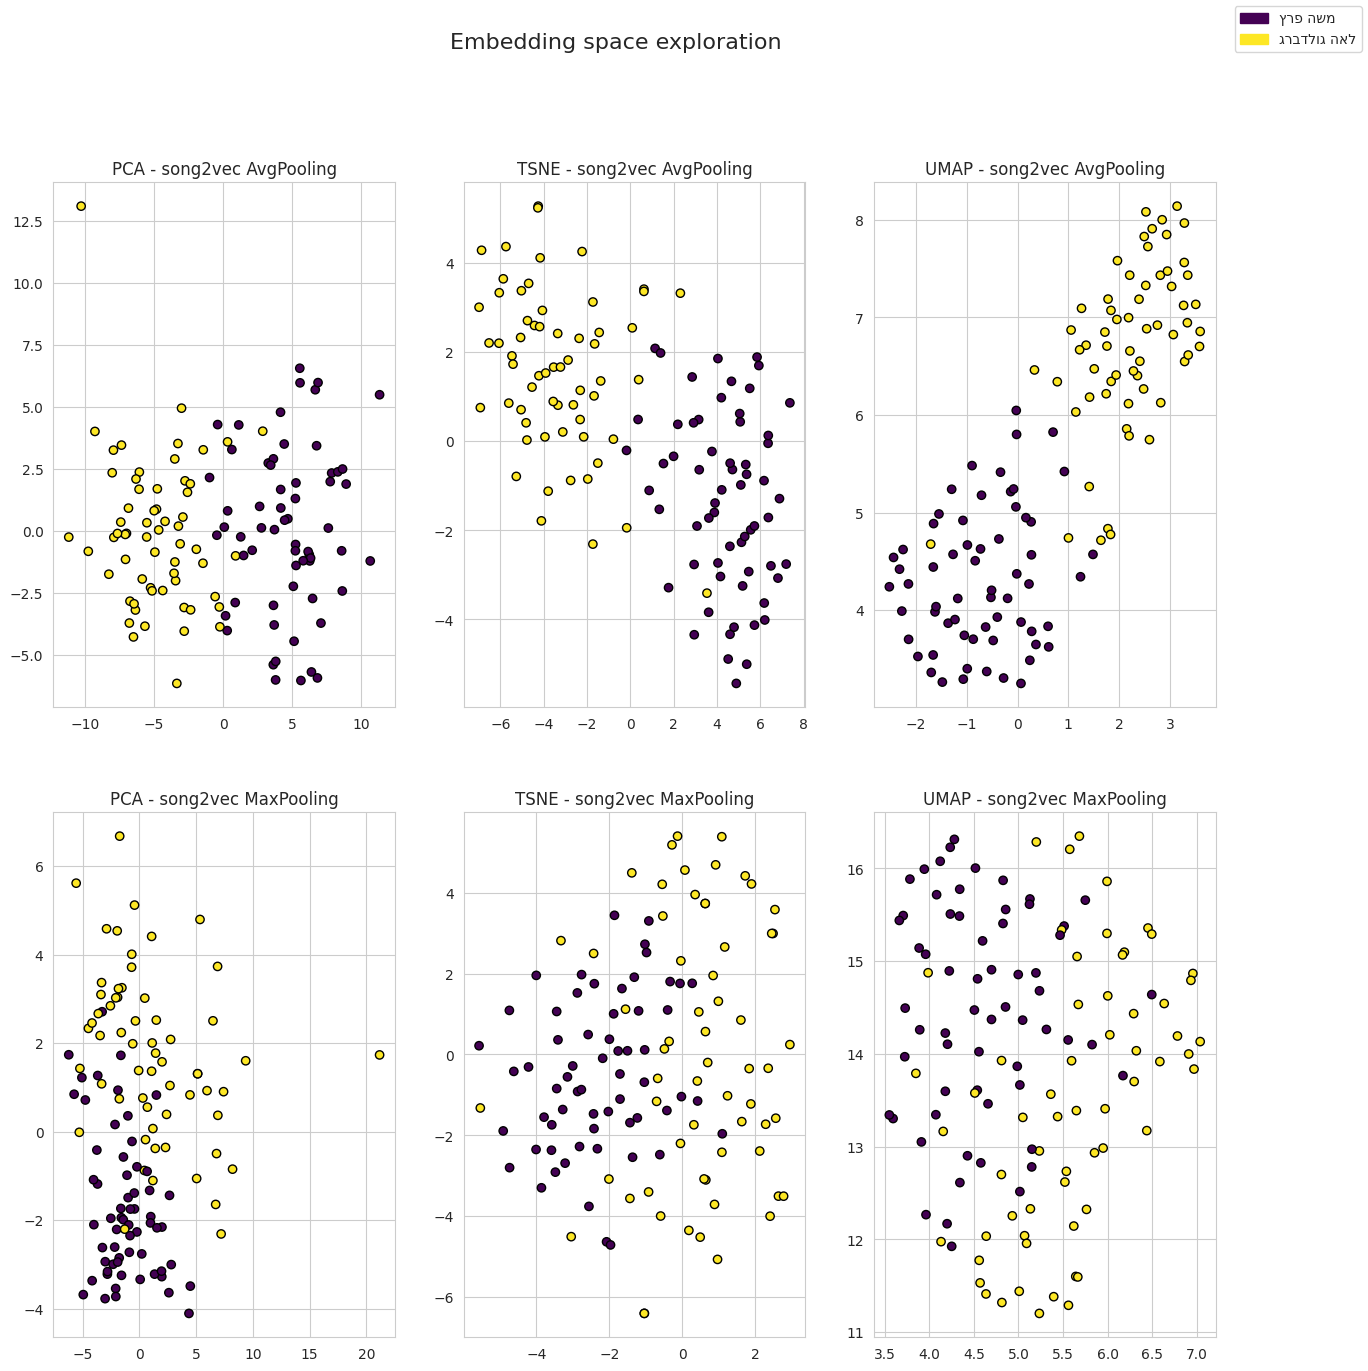

In [49]:
project_lyricists(["משה פרץ", "לאה גולדברג"])